# Data Mining Research & Practice HW3 - Time Series Regression

## 資料集:
使用新竹地區 2020 年 10-12 月之空氣品質資料，進行時間序列分析 & 迴歸預測 PM2.5 值。本資料集(如附檔)包含 AMB_TEMP、CH4、CO、NMHC、NO、NO2、NOx、O3、PM10、PM2.5、RAINFALL、RH、SO2、THC、WD_HR、WIND_DIREC、WIND_SPEED、WS_HR 共 18 種屬性(汙染物)之逐時資料。其中第一行之 0-23 代表小時。

- \# 表示儀器檢核為無效值
- \* 表示程式檢核為無效值
- x 表示人工檢核為無效值
- A 是指因儀器疑似故障警報所產生的無效值
- 空白 表示缺失值

(資料來源: https://airtw.epa.gov.tw/CHT/Query/His_Data.aspx)

## 作業：
- 使用 10 和 11 月資料當作訓練集，12 月之資料當作測試集
- 將前六小時的汙染物數據做為特徵，未來第一個小時/未來第六個小時的 PM2.5 數據為預測目標
- 使用兩種模型 Linear Regression 和 XGBoost 建模並計算 MAE

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import MaxNLocator

In [2]:
origin_df = pd.read_csv(open('新竹_2020.csv'))
origin_df.drop(0, inplace=True)
origin_df.columns = [e.strip() for e in list(origin_df.columns)]
origin_df = origin_df.applymap(lambda x: x.strip())
origin_df.head(18)

,測站,日期,測項,00,01,02,03,04,05,06,...,14,15,16,17,18,19,20,21,22,23
1,新竹,2020/01/01 00:00:00,AMB_TEMP,15.2,15.2,15.3,15.3,15.3,15.4,15.5,...,18.1,18.2,17.9,17.3,16.7,16.4,16.2,16.1,16,15.8
2,新竹,2020/01/01 00:00:00,CH4,1.74,1.74,1.77,1.78,1.77,1.77,1.77,...,1.78,1.78,1.77,1.8,1.81,1.82,1.85,1.83,1.92,1.94
3,新竹,2020/01/01 00:00:00,CO,0.28,0.25,0.24,0.22,0.2,0.19,0.2,...,0.28,0.29,0.28,0.34,0.39,0.41,0.46,0.49,0.58,0.52
4,新竹,2020/01/01 00:00:00,NMHC,0.06,0.07,0.05,0.05,0.05,0.05,0.07,...,0.09,0.09,0.07,0.08,0.12,0.12,0.16,0.14,0.17,0.2
5,新竹,2020/01/01 00:00:00,NO,0.3,0.6,0.6,0.6,0.3,0.3,0.5,...,1.6,1.6,1.2,0.7,0.9,1.1,1.1,1.7,1.8,1.4
6,新竹,2020/01/01 00:00:00,NO2,6.7,6.9,6.4,5.9,4.8,5,6.1,...,10.9,11.1,10.7,13,15.7,17.8,21.2,22.4,22.8,22.1
7,新竹,2020/01/01 00:00:00,NOx,7,7.5,6.9,6.5,5.3,5.5,6.6,...,12.5,12.8,11.9,13.7,16.6,18.9,22.4,24.1,24.6,23.5
8,新竹,2020/01/01 00:00:00,O3,33.1,33.4,33.5,32.6,33.5,33.6,32.6,...,33.9,33.1,32.8,29,24.9,21.1,15.2,13.7,11.9,12.4
9,新竹,2020/01/01 00:00:00,PM10,36,28,22,19,14,10,14,...,19,18,5,5,11,10,5,12,12,12
10,新竹,2020/01/01 00:00:00,PM2.5,21,8,8,8,9,6,5,...,2,7,6,3,6,5,7,5,8,8


## 1. 資料前處理

### a. 取出10、11、12月資料

In [3]:
month = ['10', '11', '12']
index = origin_df['日期'].map(lambda x: True if x[5:7] in month else False)
origin_df = origin_df[index]
df = origin_df.iloc[:, 3:]
origin_df

,測站,日期,測項,00,01,02,03,04,05,06,...,14,15,16,17,18,19,20,21,22,23
4933,新竹,2020/10/01 00:00:00,AMB_TEMP,23.7,23.8,23.8,23.9,23.9,23.8,24.1,...,29.9,29.6,28.7,27.5,26.4,25.7,25.5,25.3,24.9,24.5
4934,新竹,2020/10/01 00:00:00,CH4,1.97,1.95,1.96,1.96,1.95,1.96,1.97,...,1.97,1.98,1.97,2,2.03,2.04,2.05,2.02,2.1,2.14
4935,新竹,2020/10/01 00:00:00,CO,0.23,0.22,0.21,0.2,0.2,0.22,0.24,...,0.29,0.3,0.33,0.38,0.46,0.5,0.45,0.39,0.46,0.45
4936,新竹,2020/10/01 00:00:00,NMHC,0.06,0.05,0.03,0.03,0.03,0.04,0.04,...,0.06,0.07,0.09,0.11,0.13,0.15,0.1,0.07,0.12,0.18
4937,新竹,2020/10/01 00:00:00,NO,1.2,0.7,0.5,0.7,0.5,0.3,0.7,...,1.3,1,0.9,0.8,0.5,0.9,0.9,0.3,0.7,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6584,新竹,2020/12/31 00:00:00,THC,2.01,2.02,2,2,1.99,2,1.98,...,2.03,2.07,2.07,2.1,2.1,2.07,2.07,2.05,2.04,2.07
6585,新竹,2020/12/31 00:00:00,WD_HR,54,55,54,53,58,52,52,...,54,50,52,45,47,42,42,47,45,44
6586,新竹,2020/12/31 00:00:00,WIND_DIREC,53,52,57,58,49,54,36,...,48,43,44,33,50,40,46,46,51,38
6587,新竹,2020/12/31 00:00:00,WIND_SPEED,4.7,4.6,4.7,4.9,4.1,5.3,5.5,...,4.5,4.4,4.2,3.8,3.7,4.7,4.5,4.4,3.9,3.9


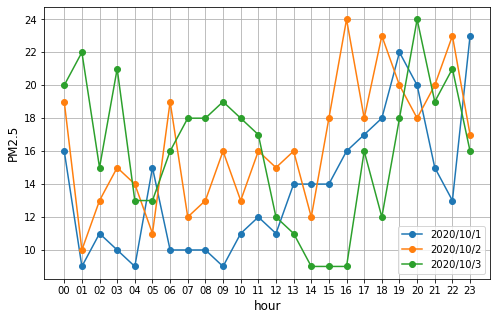

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(origin_df.iloc[9, 3:].map(lambda x: float(x)), '-o')
plt.plot(origin_df.iloc[9+18, 3:].map(lambda x: float(x)), '-o')
plt.plot(origin_df.iloc[9+18+18, 3:].map(lambda x: float(x)), '-o')
plt.grid()
plt.xlabel('hour', fontsize=12)
plt.ylabel('PM2.5', fontsize=12)
plt.legend(['2020/10/1', '2020/10/2', '2020/10/3'])
plt.show()

### b. 缺失值以及無效值以前後一小時平均值取代 (如果前一小時仍有空值，再取更前一小時)

In [5]:
def check_special_symbol(df, i, j, symbol_list):
    for s in symbol_list:
        if str(df.iloc[i, j]).rfind(s) != -1:
            return True
    else:
        return False


def get_lower_number(df, i, j, symbol_list):
    n, m = df.shape
    if i < 0:
        return -1, -1
    
    elif j==-1:
        return get_lower_number(df, i-18, m-1, symbol_list)
    
    elif check_special_symbol(df, i, j, symbol_list):
        return get_lower_number(df, i, j-1, symbol_list)
    
    else:
        return i, j

    
def get_hight_number(df, i, j, symbol_list):
    n, m = df.shape
    if i > n:
        return -1, -1
    
    elif j==len(df.columns):
        return get_hight_number(df, i+18, 0, symbol_list)
    
    elif check_special_symbol(df, i, j, symbol_list):
        return get_hight_number(df, i, j+1, symbol_list)
    
    else:
        return i, j

    
def filled_x(df):
    symbol_list = ['#', '*', 'x', 'A']
    n, m = df.shape
    for i in range(n):
        for j in range(m):
            if check_special_symbol(df, i, j, symbol_list):
                lower_index = get_lower_number(df, i, j-1, symbol_list)
                hight_index = get_hight_number(df, i, j+1, symbol_list)
                if lower_index == (-1, -1): lower_index = hight_index
                elif hight_index == (-1, -1): hight_index = lower_index
                df.iloc[i, j] = str((float(df.iloc[lower_index]) + float(df.iloc[hight_index])) / 2)
    
    return df

In [6]:
df = filled_x(df).astype(float)
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
4933,23.70,23.80,23.80,23.90,23.90,23.80,24.10,24.70,26.00,27.20,...,29.90,29.60,28.70,27.50,26.40,25.70,25.50,25.30,24.90,24.50
4934,1.97,1.95,1.96,1.96,1.95,1.96,1.97,1.97,1.96,1.98,...,1.97,1.98,1.97,2.00,2.03,2.04,2.05,2.02,2.10,2.14
4935,0.23,0.22,0.21,0.20,0.20,0.22,0.24,0.29,0.27,0.33,...,0.29,0.30,0.33,0.38,0.46,0.50,0.45,0.39,0.46,0.45
4936,0.06,0.05,0.03,0.03,0.03,0.04,0.04,0.05,0.06,0.07,...,0.06,0.07,0.09,0.11,0.13,0.15,0.10,0.07,0.12,0.18
4937,1.20,0.70,0.50,0.70,0.50,0.30,0.70,0.90,1.00,1.80,...,1.30,1.00,0.90,0.80,0.50,0.90,0.90,0.30,0.70,0.90


### c. NR表示無降雨，以0取代

In [7]:
df[df=='NR'] = 0

### d. 將資料切割成訓練集(10、11月)以及測試集(12月)

In [8]:
train_index = (31+30)*18
train_df = df.iloc[:train_index, :]
test_df = df.iloc[train_index:, :]

print(train_df.shape, test_df.shape)

(1098, 24) (558, 24)


### e. 製作時序資料: 將資料形式轉換為行(row)代表18種屬性，欄(column)代表逐時數據資料

In [9]:
train_X = np.hstack([train_df.iloc[0+18*i:18+18*i, :] for i in range(len(train_df) // 18)])
test_X = np.hstack([test_df.iloc[0+18*i:18+18*i, :] for i in range(len(test_df) // 18)])

print(train_X.shape, test_X.shape)

(18, 1464) (18, 744)


## 2. 時間序列

### a.預測目標

####  1. 將未來第一個小時當預測目標
取 6 小時為一單位切割，例如第一筆資料為第 0-5 小時的資料(X[0])，去預測第 6 小時(未來第一小時)的 PM2.5 值(Y[0])，下一筆資料為第 1-6 小時的資料(X[1])去預測第 7 小時的 PM2.5 值(Y[1]) (hint: 切割後 X 的長度應為 1464-6=1458)

In [10]:
def get_time_series_label(df, pred_hour_unit, PM2p5=9):
    return np.vstack([df[PM2p5, pred_hour_unit+i] for i in range(df.shape[1]-pred_hour_unit)])

In [11]:
train_Y_c6_p6 = get_time_series_label(train_X, pred_hour_unit=6)
test_Y_c6_p6  = get_time_series_label(test_X, pred_hour_unit=6)
print(train_Y_c6_p6.shape)
print(test_Y_c6_p6.shape)

(1458, 1)
(738, 1)


####  2. 將未來第六個小時當預測目標
取 6 小時為一單位切割，例如第一筆資料為第 0-5 小時的資料(X[0])，去預測第 11 小時(未來第六小時)的 PM2.5 值(Y[0])，下一筆資料為第 1-6 小時的資料(X[1])去預測第 12 小時的 PM2.5 值(Y[1]) (hint: 切割後 X 的長度應為 1464-11=1453)

In [12]:
train_Y_c6_p11 = get_time_series_label(train_X, pred_hour_unit=11)
test_Y_c6_p11  = get_time_series_label(test_X, pred_hour_unit=11)
print(train_Y_c6_p11.shape)
print(test_Y_c6_p11.shape)

(1453, 1)
(733, 1)


### b. X 請分別取

#### 1. 只有 PM2.5 (e.g. X[0] 會有6個特徵，即第 0-5 小時的 PM2.5 數值)

In [13]:
def get_time_series_data(df, cut_unit, pred_hour_unit, PM2p5):
    return np.vstack([df[PM2p5, 0+i:cut_unit+i].reshape(1, -1) for i in range(df.shape[1]-pred_hour_unit)])

In [14]:
train_X_c6_p6_f1 = get_time_series_data(train_X, cut_unit=6, pred_hour_unit=6, PM2p5=9)
test_X_c6_p6_f1  = get_time_series_data(test_X, cut_unit=6, pred_hour_unit=6, PM2p5=9)
print(train_X_c6_p6_f1.shape)
print(test_X_c6_p6_f1.shape)

(1458, 6)
(738, 6)


In [15]:
train_X_c6_p11_f1 = get_time_series_data(train_X, cut_unit=6, pred_hour_unit=11, PM2p5=9)
test_X_c6_p11_f1  = get_time_series_data(test_X, cut_unit=6, pred_hour_unit=11, PM2p5=9)
print(train_X_c6_p11_f1.shape)
print(test_X_c6_p11_f1.shape)

(1453, 6)
(733, 6)


#### 2. 所有18種屬性 (e.g. X[0]會有18*6個特徵，即第0~5小時的所有18種屬性數值)

In [16]:
train_X_c6_p6_f18 = get_time_series_data(train_X, cut_unit=6, pred_hour_unit=6, PM2p5=range(18))
test_X_c6_p6_f18  = get_time_series_data(test_X, cut_unit=6, pred_hour_unit=6, PM2p5=range(18))
print(train_X_c6_p6_f18.shape)
print(test_X_c6_p6_f18.shape)

(1458, 108)
(738, 108)


In [17]:
train_X_c6_p11_f18 = get_time_series_data(train_X, cut_unit=6, pred_hour_unit=11, PM2p5=range(18))
test_X_c6_p11_f18  = get_time_series_data(test_X, cut_unit=6, pred_hour_unit=11, PM2p5=range(18))
print(train_X_c6_p11_f18.shape)
print(test_X_c6_p11_f18.shape)

(1453, 108)
(733, 108)


In [18]:
data_list = [
    (train_X_c6_p6_f1, train_Y_c6_p6, test_X_c6_p6_f1, test_Y_c6_p6),
    (train_X_c6_p6_f18, train_Y_c6_p6, test_X_c6_p6_f18, test_Y_c6_p6),
    (train_X_c6_p11_f1, train_Y_c6_p11, test_X_c6_p11_f1, test_Y_c6_p11),
    (train_X_c6_p11_f18, train_Y_c6_p11, test_X_c6_p11_f18, test_Y_c6_p11)
]

### c. 使用兩種模型 Linear Regression 和 XGBoost 建模

In [19]:
def Modeling(data_list, model):
    train_mae_list = []
    test_mae_list = []
    r2_list = []
    
    for tr_X, tr_Y, ts_X, ts_Y in data_list:
        model.fit(tr_X, tr_Y)
        train_pred = model.predict(tr_X)
        test_pred = model.predict(ts_X)
        
        train_mae = metrics.mean_absolute_error(tr_Y, train_pred)
        test_mae = metrics.mean_absolute_error(ts_Y, test_pred)
        r2 = metrics.r2_score(ts_Y, test_pred)
        
        train_mae_list.append(round(train_mae, 4))
        test_mae_list.append(round(test_mae, 4))
        r2_list.append(round(r2, 4))
    
    return train_mae_list, test_mae_list, r2_list

In [20]:
lr_model = LinearRegression()
lr_train_mae, lr_test_mae, lr_r2_list = Modeling(data_list, lr_model)

In [21]:
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', verbosity=2)
xgboost_train_mae, xgboost_test_mae, xgboost_r2_list = Modeling(data_list, xgboost_model)

[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 

[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes

[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 

[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[15:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 

[15:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[15:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[15:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[15:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[15:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes,

[15:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[15:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[15:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[15:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[15:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[15:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0

### d. 用測試集資料計算MAE (會有8個結果， 2種X資料 * 2種Y資料 * 2種模型)

In [22]:
print('Training:')
print(f'Linear Regression MAE: {lr_train_mae}')
print(f'Xgboost           MAE: {xgboost_train_mae}')

Training:
Linear Regression MAE: [2.5727, 2.2964, 4.0234, 3.6254]
Xgboost           MAE: [0.6177, 0.0864, 1.0306, 0.0771]


In [23]:
print('Testing:')
print(f'Linear Regression MAE: {lr_test_mae}')
print(f'Xgboost           MAE: {xgboost_test_mae}')

Testing:
Linear Regression MAE: [2.5224, 2.6959, 4.5794, 6.0882]
Xgboost           MAE: [3.0083, 2.9761, 5.0085, 4.6741]


In [24]:
print(f'Linear Regression R-squared: {lr_r2_list}')
print(f'Xgboost           R-squared: {xgboost_r2_list}')

Linear Regression R-squared: [0.8493, 0.823, 0.4728, 0.2654]
Xgboost           R-squared: [0.7653, 0.7873, 0.393, 0.4166]


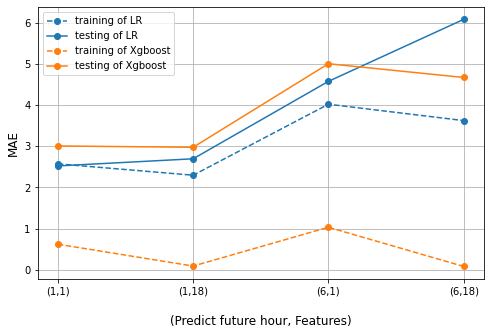

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(["(1,1)", "(1,18)", "(6,1)", "(6,18)"], lr_train_mae, '--o', color='tab:blue')
plt.plot(["(1,1)", "(1,18)", "(6,1)", "(6,18)"], lr_test_mae, '-o', color='tab:blue')
plt.plot(["(1,1)", "(1,18)", "(6,1)", "(6,18)"], xgboost_train_mae, '--o', color='tab:orange')
plt.plot(["(1,1)", "(1,18)", "(6,1)", "(6,18)"], xgboost_test_mae, '-o', color='tab:orange')
plt.grid()
plt.xlabel("\n(Predict future hour, Features)", fontsize=12)
plt.ylabel("MAE", fontsize=12)
#plt.title("Mean Absolute Error (MAE)", fontsize=16)
plt.legend(['training of LR',
            'testing of LR',
            'training of Xgboost',
            'testing of Xgboost'])

## 3.預測結果

In [26]:
tmp_model = LinearRegression()
tmp_model.fit(train_X_c6_p6_f1, train_Y_c6_p6)
lr_pred_f1 = tmp_model.predict(test_X_c6_p6_f1)

tmp_model = LinearRegression()
tmp_model.fit(train_X_c6_p6_f18, train_Y_c6_p6)
lr_pred_f18 = tmp_model.predict(test_X_c6_p6_f18)

tmp_model = xgb.XGBRegressor()
tmp_model.fit(train_X_c6_p6_f1, train_Y_c6_p6)
xg_pred_f1 = tmp_model.predict(test_X_c6_p6_f1)

tmp_model = xgb.XGBRegressor()
tmp_model.fit(train_X_c6_p6_f18, train_Y_c6_p6)
xg_pred_f18 = tmp_model.predict(test_X_c6_p6_f18)

[15:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[15:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[15:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[15:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[15:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[15:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 

[15:50:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:50:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[15:50:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[15:50:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[15:50:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[15:50:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 

[15:50:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[15:50:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[15:50:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[15:50:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[15:50:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[15:50:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0

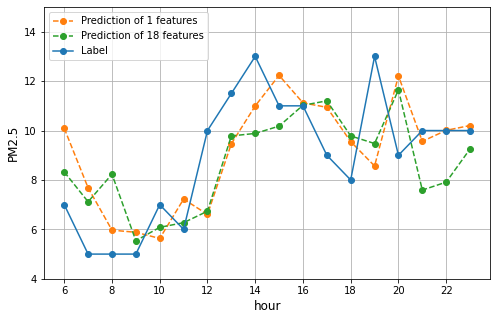

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(range(6, 24), lr_pred_f1[:18].T.squeeze(), '--o', color='tab:orange')
plt.plot(range(6, 24), lr_pred_f18[:18].T.squeeze(), '--o', color='tab:green')
plt.plot(range(6, 24), test_Y_c6_p6[:18].T.squeeze(), '-o', color='tab:blue')
plt.xlabel('hour', fontsize=12)
plt.ylabel('PM2.5', fontsize=12)
plt.ylim([4, 15])
plt.legend(['Prediction of 1 features', 'Prediction of 18 features', 'Label'])
plt.grid()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

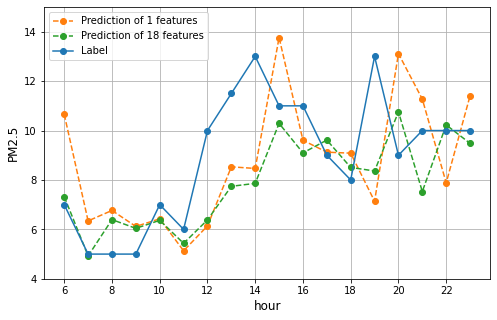

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(range(6, 24), xg_pred_f1[:18].T.squeeze(), '--o', color='tab:orange')
plt.plot(range(6, 24), xg_pred_f18[:18].T.squeeze(), '--o', color='tab:green')
plt.plot(range(6, 24), test_Y_c6_p6[:18].T.squeeze(), '-o', color='tab:blue')
plt.xlabel('hour', fontsize=12)
plt.ylabel('PM2.5', fontsize=12)
plt.ylim([4, 15])
plt.legend(['Prediction of 1 features', 'Prediction of 18 features', 'Label'])
plt.grid()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))